**for sending data from notebook to BigQuery**

In [3]:
pip install google-cloud-bigquery pandas pyarrow db-dtypes

**Login from Colab to GCP**

In [4]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated.")

Authenticated.


**Connect to BigQuery project**

In [5]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "sfo-lakehouse-226"
client = bigquery.Client(project=PROJECT_ID)
print("Connected to:", client.project)


Connected to: sfo-lakehouse-226


**Create the schemas**

In [6]:
datasets = ["sfo_raw", "sfo_core", "sfo_marts"]

for ds in datasets:
    dataset_id = f"{PROJECT_ID}.{ds}"
    dataset = bigquery.Dataset(dataset_id)
    dataset.location = "US"
    try:
        client.create_dataset(dataset)
        print("Created:", dataset_id)
    except Exception:
        print("Already exists:", dataset_id)


Already exists: sfo-lakehouse-226.sfo_raw
Already exists: sfo-lakehouse-226.sfo_core
Already exists: sfo-lakehouse-226.sfo_marts


**Load both CSV in pandas and check if data is correct**

In [10]:
import io

df_passenger = pd.read_csv("/Air_Traffic_Passenger_Statistics.csv")
df_landings  = pd.read_csv("/Air_Traffic_Landings_Statistics.csv")

print("Passenger shape:", df_passenger.shape)
print("Landings shape :", df_landings.shape)
df_passenger.head()


Passenger shape: (38370, 15)
Landings shape : (44172, 17)


,Activity Period,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_as_of,data_loaded_at
0,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,31432,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM
1,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,31353,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM
2,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,2518,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM
3,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Deplaned,Other,Terminal 2,D,1324,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM
4,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Enplaned,Other,Terminal 2,D,1198,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM


In [12]:
#fix datatype of activity period

df_passenger["Activity Period"] = df_passenger["Activity Period"].astype("int64")
df_landings["Activity Period"]  = df_landings["Activity Period"].astype("int64")
print("Converted Activity Period to int64")

Converted Activity Period to int64


**Load data from pandas to BigQuery**

In [13]:
from google.cloud import bigquery

#create load job configuration
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

table_pass = f"{PROJECT_ID}.sfo_raw.passenger_raw"
table_land = f"{PROJECT_ID}.sfo_raw.landings_raw"

job = client.load_table_from_dataframe(df_passenger, table_pass, job_config=job_config)
job.result()
print("Loaded:", table_pass)

job = client.load_table_from_dataframe(df_landings, table_land, job_config=job_config)
job.result()
print("Loaded:", table_land)


Loaded: sfo-lakehouse-226.sfo_raw.passenger_raw
Loaded: sfo-lakehouse-226.sfo_raw.landings_raw


In [14]:
#check row count in both table
for t in ["passenger_raw", "landings_raw"]:
  q = f"SELECT COUNT(*) AS `rows` FROM `{PROJECT_ID}.sfo_raw.{t}`"
  print(t, client.query(q).to_dataframe().iloc[0]["rows"])

passenger_raw 38370
landings_raw 44172


**Insights**

In [18]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Colab me already hota hai; nahi ho to: !pip install seaborn

sns.set(style="whitegrid")
PROJECT_ID = "sfo-lakehouse-226"
client = bigquery.Client(project=PROJECT_ID)

**Airline Mix – Top 10 Airlines**

In [53]:
query_top10_airlines = """
SELECT
  REGEXP_REPLACE(operating_airline, r' - PRE .*', '') AS operating_airline,
  SUM(passengers_excl_transit) AS total_pax_excl_transit
FROM `sfo-lakehouse-226.sfo_marts.mart_airline_mix_monthly`
WHERE year = 2023
GROUP BY operating_airline
ORDER BY total_pax_excl_transit DESC
LIMIT 10
"""

df_air_top10 = client.query(query_top10_airlines).to_dataframe()
df_air_top10

,operating_airline,total_pax_excl_transit
0,UNITED AIRLINES,83583620
1,SKYWEST AIRLINES,6662604
2,ALASKA AIRLINES,3941893
3,DELTA AIR LINES,3887712
4,AMERICAN AIRLINES,3070705
5,SOUTHWEST AIRLINES,2120725
6,JETBLUE AIRWAYS,1369534
7,FRONTIER AIRLINES,1134531
8,AIR CANADA,922179
9,EVA AIRWAYS,594269


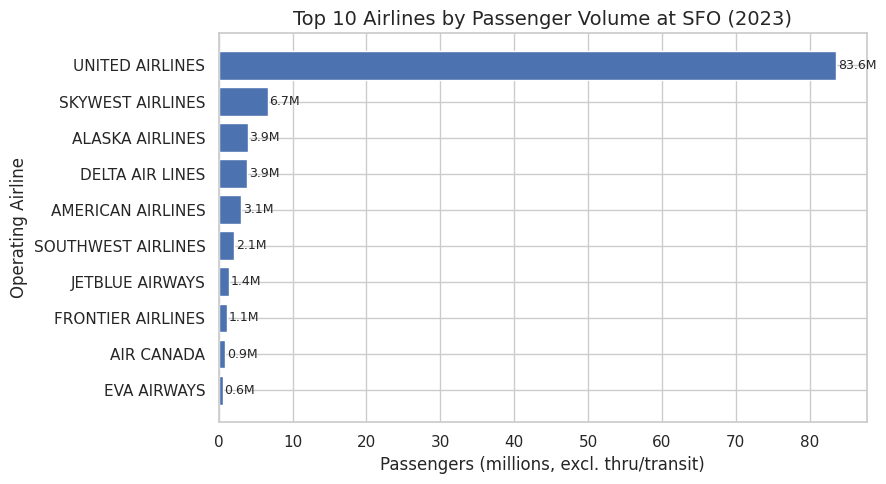

In [54]:
df_plot = df_air_top10.copy()
df_plot["pax_millions"] = df_plot["total_pax_excl_transit"] / 1_000_000
df_plot = df_plot.sort_values("pax_millions", ascending=True).reset_index(drop=True)

plt.figure(figsize=(9, 5))
plt.barh(df_plot["operating_airline"], df_plot["pax_millions"])

plt.title("Top 10 Airlines by Passenger Volume at SFO (2023)", fontsize=14)
plt.xlabel("Passengers (millions, excl. thru/transit)", fontsize=12)
plt.ylabel("Operating Airline", fontsize=12)

for i, v in enumerate(df_plot["pax_millions"]):
    plt.text(v + 0.2, i, f"{v:.1f}M", va="center", fontsize=9)

plt.tight_layout()
plt.show()

**Area that are busiest**

In [43]:
query_terminal_top10 = """
SELECT
  year,
  terminal,
  boarding_area,
  SUM(pax_excl_transit) AS total_pax_excl_transit
FROM `sfo-lakehouse-226.sfo_marts.mart_terminal_load_monthly`
WHERE year = 2023
  AND terminal IS NOT NULL
GROUP BY year, terminal, boarding_area
ORDER BY total_pax_excl_transit DESC
LIMIT 10
"""

df_term = client.query(query_terminal_top10).to_dataframe()
df_term

,year,terminal,boarding_area,total_pax_excl_transit
0,2023,TERMINAL 3,F,46708510
1,2023,INTERNATIONAL,G,22605009
2,2023,TERMINAL 3,E,22046604
3,2023,TERMINAL 2,D,7555776
4,2023,TERMINAL 1,B,6730858
5,2023,INTERNATIONAL,A,6293092
6,2023,TERMINAL 1,C,3971737


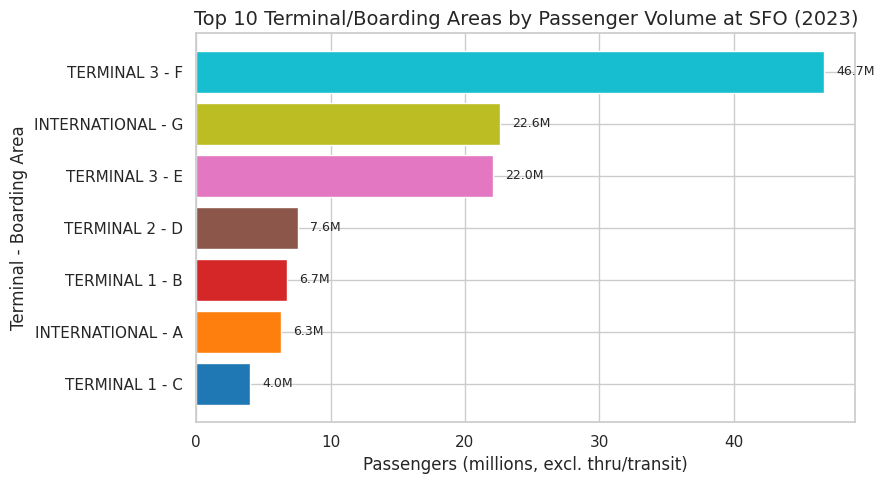

In [44]:
df_term_plot = df_term.copy()
df_term_plot["pax_millions"] = df_term_plot["total_pax_excl_transit"] / 1_000_000
df_term_plot["label"] = df_term_plot["terminal"] + " - " + df_term_plot["boarding_area"]

# sort small→big for neat bars
df_term_plot = df_term_plot.sort_values("pax_millions", ascending=True).reset_index(drop=True)

plt.figure(figsize=(9, 5))

colors = plt.cm.tab10(np.linspace(0, 1, len(df_term_plot)))
plt.barh(df_term_plot["label"], df_term_plot["pax_millions"], color=colors)

plt.title("Top 10 Terminal/Boarding Areas by Passenger Volume at SFO (2023)", fontsize=14)
plt.xlabel("Passengers (millions, excl. thru/transit)", fontsize=12)
plt.ylabel("Terminal - Boarding Area", fontsize=12)

xmax = df_term_plot["pax_millions"].max()
for i, v in enumerate(df_term_plot["pax_millions"]):
    plt.text(v + xmax * 0.02, i, f"{v:.1f}M", va="center", fontsize=9)

plt.tight_layout()
plt.show()

**Main KPI – Passengers per Landing (Overall SFO)**

In [61]:
query_ppl_overall = """
SELECT
  year,
  month,
  date_id,
  SUM(passengers_excl_transit) AS total_pax_excl_transit,
  SUM(landings) AS total_landings,
  SAFE_DIVIDE(SUM(passengers_excl_transit), SUM(landings)) AS passengers_per_landing
FROM `sfo-lakehouse-226.sfo_marts.mart_passengers_per_landing`
GROUP BY year, month, date_id
ORDER BY date_id
"""

df_ppl_overall = client.query(query_ppl_overall).to_dataframe()
df_ppl_overall.head(), df_ppl_overall.shape

(   year  month  date_id  total_pax_excl_transit  total_landings  \
 0  1999      7   199907                10298827           44612   
 1  1999      8   199908                10357166           44036   
 2  1999      9   199909                 8795942           41832   
 3  1999     10   199910                 9128272           43813   
 4  1999     11   199911                 8201664           39691   
 
    passengers_per_landing  
 0              230.853291  
 1              235.197702  
 2              210.268264  
 3              208.346199  
 4              206.637878  ,
 (312, 6))

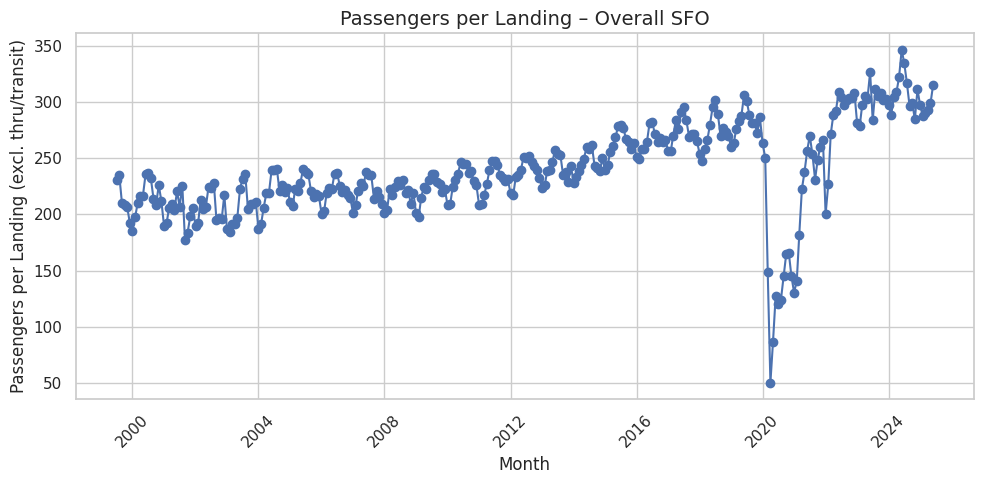

In [62]:
df_ppl_overall["year_month"] = pd.to_datetime(
    df_ppl_overall["year"].astype(str) + "-" +
    df_ppl_overall["month"].astype(str) + "-01"
)

plt.figure(figsize=(10, 5))
plt.plot(df_ppl_overall["year_month"],
         df_ppl_overall["passengers_per_landing"],
         marker="o")

plt.title("Passengers per Landing – Overall SFO", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers per Landing (excl. thru/transit)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Fleet Mix (Wide vs Narrow Body)**

In [86]:
query_fleet = """
SELECT
  year,
  month,
  body_bucket,
  total_landings
FROM `sfo-lakehouse-226.sfo_marts.mart_fleet_mix_monthly`
WHERE year = 2023
ORDER BY year, month, body_bucket
"""
df_fleet = client.query(query_fleet).to_dataframe()

print(df_fleet["body_bucket"].value_counts())
df_fleet.head()

body_bucket
NARROW-BODY    12
WIDE-BODY      12
Name: count, dtype: int64


,year,month,body_bucket,total_landings
0,2023,1,NARROW-BODY,21944
1,2023,1,WIDE-BODY,5934
2,2023,2,NARROW-BODY,20798
3,2023,2,WIDE-BODY,5484
4,2023,3,NARROW-BODY,24148


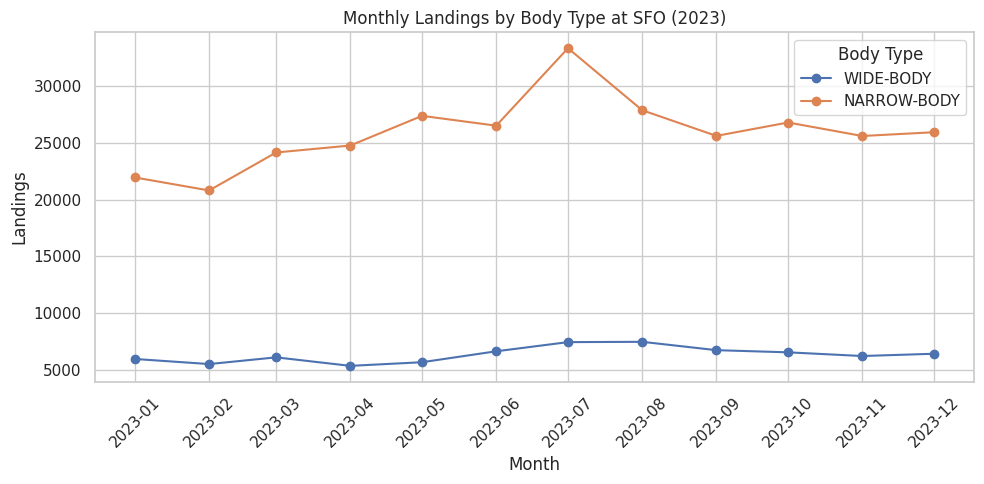

In [87]:
df_trend = (
    df_fleet
    .groupby(["year", "month", "body_bucket"], as_index=False)["total_landings"]
    .sum()
    .pivot_table(
        index=["year", "month"],
        columns="body_bucket",
        values="total_landings",
        fill_value=0
    )
    .reset_index()
)

df_trend = df_trend.sort_values(["year", "month"])
df_trend["year_month"] = pd.to_datetime(
    df_trend["year"].astype(str) + "-" +
    df_trend["month"].astype(str) + "-01"
)

plt.figure(figsize=(10, 5))

for col in [c for c in ["WIDE-BODY", "NARROW-BODY", "OTHER"] if c in df_trend.columns]:
    plt.plot(df_trend["year_month"], df_trend[col], marker="o", label=col)

plt.title("Monthly Landings by Body Type at SFO (2023)")
plt.xlabel("Month")
plt.ylabel("Landings")
plt.xticks(df_trend["year_month"],
           df_trend["year_month"].dt.strftime("%Y-%m"),
           rotation=45)
plt.legend(title="Body Type")
plt.tight_layout()
plt.show()

**To check couchdb is connected to BigQuery**

In [78]:
query_count = """
SELECT COUNT(*) AS row_count
FROM `sfo-lakehouse-226.sfo_raw.passenger_from_couch`
"""

df_count = client.query(query_count).to_dataframe()
df_count

,row_count
0,1500


**Region wise Passenger**

In [80]:
query_couch_geo = """
SELECT
  `GEO Region` AS geo_region,
  SUM(CAST(`Passenger Count` AS INT64)) AS total_passengers
FROM `sfo-lakehouse-226.sfo_raw.passenger_from_couch`
GROUP BY
  geo_region
ORDER BY
  total_passengers DESC
"""

df_couch_geo = client.query(query_couch_geo).to_dataframe()
df_couch_geo

,geo_region,total_passengers
0,US,36197913
1,Asia,3066162
2,Europe,2540676
3,Canada,1191408
4,Mexico,553170
5,Australia / Oceania,152133
6,Central America,80088


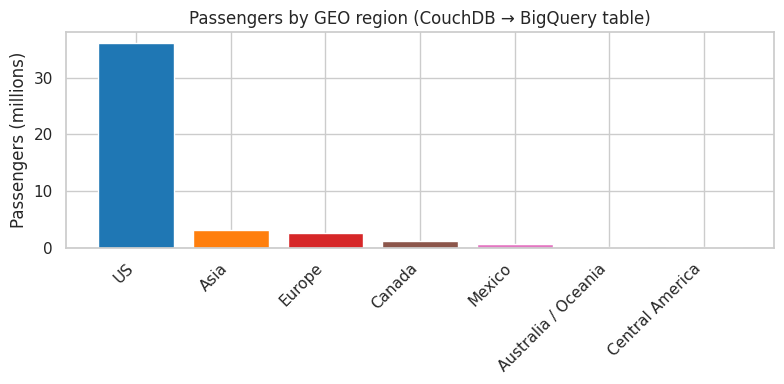

In [82]:
plt.figure(figsize=(8, 4))
plt.bar(df_couch_geo["geo_region"], df_couch_geo["total_passengers"] / 1_000_000, color=colors)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Passengers (millions)")
plt.title("Passengers by GEO region (CouchDB → BigQuery table)")
plt.tight_layout()
plt.show()

**YoY growth by region**

In [83]:
query_yoy_region = """
WITH yearly_region AS (
  SELECT
    year,
    geo_region,
    SUM(passengers_excl_transit) AS passengers_excl_transit
  FROM `sfo-lakehouse-226.sfo_marts.mart_airline_mix_monthly`
  GROUP BY
    year,
    geo_region
),
with_prev AS (
  SELECT
    year,
    geo_region,
    passengers_excl_transit,
    LAG(passengers_excl_transit) OVER (
      PARTITION BY geo_region
      ORDER BY year
    ) AS prev_year_pax
  FROM yearly_region
)
SELECT
  year,
  geo_region,
  passengers_excl_transit AS total_passengers,
  prev_year_pax,
  SAFE_DIVIDE(
    passengers_excl_transit - prev_year_pax,
    prev_year_pax
  ) AS yoy_growth_ratio
FROM with_prev
WHERE prev_year_pax IS NOT NULL
ORDER BY
  geo_region,
  year;
"""

df_yoy_region = client.query(query_yoy_region).to_dataframe()
df_yoy_region

,year,geo_region,total_passengers,prev_year_pax,yoy_growth_ratio
0,2000,ASIA,7959724,3213573,1.476908
1,2001,ASIA,7569106,7959724,-0.049074
2,2002,ASIA,7792478,7569106,0.029511
3,2003,ASIA,6620972,7792478,-0.150338
4,2004,ASIA,7945481,6620972,0.200048
...,...,...,...,...,...
199,2021,US,47297946,29793691,0.587515
200,2022,US,77437037,47297946,0.637218
201,2023,US,86172992,77437037,0.112814
202,2024,US,87918286,86172992,0.020253


**Domestic vs International share**

In [84]:
query_dom_intl = """
WITH classified AS (
  SELECT
    year,
    CASE
      WHEN UPPER(geo_region) = 'NORTH AMERICA' THEN 'DOMESTIC'
      ELSE 'INTERNATIONAL'
    END AS market_type,
    passengers_excl_transit
  FROM `sfo-lakehouse-226.sfo_marts.mart_airline_mix_monthly`
)
, yearly_sums AS (
  SELECT
    year,
    market_type,
    SUM(passengers_excl_transit) AS total_passengers
  FROM classified
  GROUP BY
    year,
    market_type
),
with_share AS (
  SELECT
    year,
    market_type,
    total_passengers,
    SAFE_DIVIDE(
      total_passengers,
      SUM(total_passengers) OVER (PARTITION BY year)
    ) AS share_of_passengers
  FROM yearly_sums
)
SELECT
  year,
  market_type,
  total_passengers,
  share_of_passengers
FROM with_share
ORDER BY
  year,
  market_type;
"""

df_dom_intl = client.query(query_dom_intl).to_dataframe()
df_dom_intl

,year,market_type,total_passengers,share_of_passengers
0,1999,INTERNATIONAL,54880572,1.0
1,2000,INTERNATIONAL,104020287,1.0
2,2001,INTERNATIONAL,88454087,1.0
3,2002,INTERNATIONAL,78750373,1.0
4,2003,INTERNATIONAL,72379930,1.0
5,2004,INTERNATIONAL,79886761,1.0
6,2005,INTERNATIONAL,79840117,1.0
7,2006,INTERNATIONAL,81324018,1.0
8,2007,INTERNATIONAL,84415945,1.0
9,2008,INTERNATIONAL,83633635,1.0


**Bonus: Month-of-year seasonality by region**

In [85]:
query_seasonality = """
SELECT
  month,
  geo_region,
  AVG(monthly_pax) AS avg_monthly_passengers
FROM (
  SELECT
    year,
    month,
    geo_region,
    SUM(passengers_excl_transit) AS monthly_pax
  FROM `sfo-lakehouse-226.sfo_marts.mart_airline_mix_monthly`
  GROUP BY
    year,
    month,
    geo_region
)
GROUP BY
  month,
  geo_region
ORDER BY
  month,
  avg_monthly_passengers DESC;
"""

df_seasonality = client.query(query_seasonality).to_dataframe()
df_seasonality

,month,geo_region,avg_monthly_passengers
0,1,US,5.361737e+06
1,1,ASIA,7.358089e+05
2,1,EUROPE,2.993495e+05
3,1,MEXICO,1.956803e+05
4,1,CANADA,1.664640e+05
...,...,...,...
103,12,CANADA,1.794442e+05
104,12,AUSTRALIA / OCEANIA,1.251345e+05
105,12,MIDDLE EAST,4.541594e+04
106,12,CENTRAL AMERICA,1.854065e+04
